IEEE CIS - Semana 2

Nessa semana iremos avaliar o Dataset Red Wine Quality, disponível no https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

O objetivo é utilizar uma abordagem de Machine Learning para prever se o vinho é Tinto ou não, com base em suas características físicas.

In [1]:
#Importando Bibliotecas
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from math import sqrt
import csv

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split #Para separa o conjunto de teste do de treino

from scipy.stats import mode

from collections import Counter


In [2]:
#Abrindo o Dataset
wine = pd.read_csv("winequality.csv")
wine.drop(axis=1 , columns=["Unnamed: 0"], inplace=True) #Removendo coluna de index não útil

#Como a caracterização foco do aprendizado é a categoria binária wine_is_red, então vamos verificar
# a sua distribuição no conjunto
c_alvo = wine["wine_is_red"].value_counts()

Podemos perceber que existe uma discrepância de mais de 3000 no número de casos em que o vinho não é tinto, para os casos em que ele é tinto. O que pode ser um fator de viés para um algoritmo mais complexo de aprendizado computacional.

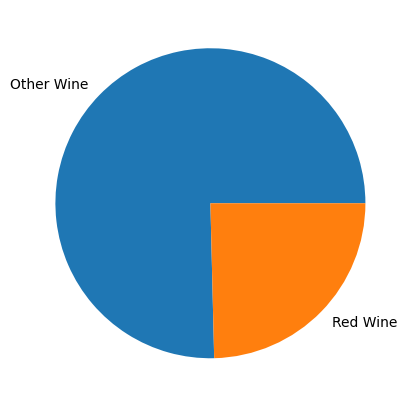

In [3]:
fig = plt.figure(figsize =(5, 7)) 
plt.pie(c_alvo, labels = ['Other Wine', 'Red Wine']) 
plt.show() 

Para prosseguir com a avaliação podemos averiguar se existem valores nulos ou não numéricos.

In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_is_red           6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


Portanto, como todos os valores são numéricos e não apresentam nulos, podemos aplicar o algoritmo de KNN recomendado no desafio.

In [5]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6,1
1,8.2,1.00,0.09,2.3,0.065,7.0,37.0,0.99685,3.32,0.55,9.0,6,1
2,6.4,0.24,0.49,5.8,0.053,25.0,120.0,0.99420,3.01,0.98,10.5,6,0
3,6.6,0.23,0.26,1.3,0.045,16.0,128.0,0.99340,3.36,0.60,10.0,6,0
4,7.2,0.24,0.29,3.0,0.036,17.0,117.0,0.99411,3.36,0.68,10.1,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,7.7,0.32,0.62,10.6,0.036,56.0,153.0,0.99780,3.13,0.44,8.9,6,0
6493,6.2,0.22,0.28,2.2,0.040,24.0,125.0,0.99170,3.19,0.48,10.5,6,0
6494,7.9,0.33,0.28,31.6,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6,0
6495,7.0,0.30,0.28,2.2,0.042,21.0,177.0,0.99166,3.20,0.57,11.4,5,0


# Algoritmo de KNN com Numpy

O KNN (K-Nearest Neighbors) é um algoritmo de aprendizado supervisionado que classifica dados conforme a distância entre grupos de pontos de dados.

Método de funcionamento, dado um ponto que deseja ser analisado:

- Calcula a distancia desse ponto para todos os outros do dataset

- Pega os K pontos mais próximos (distancia)

- Decide a classificação (conforme o voto de maioria)

In [6]:
# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = euclidean_distance(test_row, train_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors

# Make a prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction

# kNN Algorithm
def k_nearest_neighbors(train, test, num_neighbors):
	predictions = list()
	for row in test:
		output = predict_classification(train, row, num_neighbors)
		predictions.append(output)
	return(predictions)

# Calculate accuracy percentage
def accuracy_metric(df_test, predicted):
    correct = 0
    answers = [row[-1] for row in df_test]
    for i in range(len(answers)):
        if answers[i] == predicted[i]:
            correct += 1
    return correct / float(len(answers)) * 100.0

## Aplicando o algoritmo no Dataset

O dataset winequality.csv contém 12 variáveis de entrada, as quais representam valores de características químicas e físicas do vinho, e uma variável binária de saída que informa se o vinho é tinto ou não.

Como estamos trabalhando com um dataset onde as variáveis de entrada apresentam diferentes magnitudes nos valores medidos e a distância é calculada conforme a soma das distância entre os valores, é interessante que o conjunto seja normalizado. (será testado futuramente na etapa de avaliação dos resultados se essa foi uma boa abordagem)

In [7]:
#Passo 1 - Pre-processamento do dataset
#1 - Normalização do dataset
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

wine_n = normalize(wine)

#2 - Transformar o dataset em uma lista
dataset = wine.values.tolist()
datasetN = wine_n.values.tolist()

Como temos um conjunto único para treinar e para testar o sistema, então precisamos dividi-lo para testar a acurácia dos resultados. Iremos dividir de forma que 30% do conjunto de dados seja para treino e 70% para teste.

In [20]:
#Passo 3 - Dividir o dataset para treino e para teste
datasetN_train , datasetN_test = train_test_split(datasetN, test_size =0.3, random_state=18)

#Passo 4 - Aplicar o algorítmo KNN no conjunto de teste e salvar as predições
predictedN = k_nearest_neighbors(datasetN_train, datasetN_test, 5) #Usando 5 vizinhos próximos

In [22]:
#Passo 5 - Verificar a acuracia da previsão
accuracy_metric(datasetN_test, predictedN)

99.28205128205128

Podemos perceber que nessas circunstâncias a acurácia foi de 99%, o que é ótimo! Vamos agora avaliar se esse valor se altera ao utilizar o dataset não normalizado.

In [24]:
dataset_train , dataset_test = train_test_split(dataset, test_size =0.3, random_state=18)
predicted = k_nearest_neighbors(dataset_train, dataset_test, 5) #Usando 5 vizinhos próximos

In [26]:
accuracy_metric(datasetN_test, predicted)

94.41025641025641

Podemos perceber que se o dataset não fosse normalizado, a acurácia da previsão é menor, o que já era esperado.

## Conclusão

Portanto, pode-se perceber que o método KNN, apesar de ser um método básico de predição, para alguns casos ele pode apresentar ótimos resultados, como esse que vimos. 

Para futuras análises seria interessante avaliar o desempenho do método KNN com outros métodos não supervisionados mais complexos, para ver se realmente ele é o mais adequado.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=082f263f-d38b-41b7-80da-910e7a784df2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>